In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import src

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [3]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

### Setup for data

In [4]:
expLabels = [
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
    'Test 22',
    'Test 23',
    'Test 24',
    'Test 25',
    'Test 26',
]

exps = [src.load(label) for label in expLabels]

In [5]:
dfs = [exp.features.copy() for exp in exps]

In [6]:
data_y = dfs[0]['Mean radius'].values[1:].reshape(-1, 1)
data_x = np.arange(1, len(data_y) + 1).reshape(-1, 1)

Text(0, 0.5, 'Mean radius (mm)')

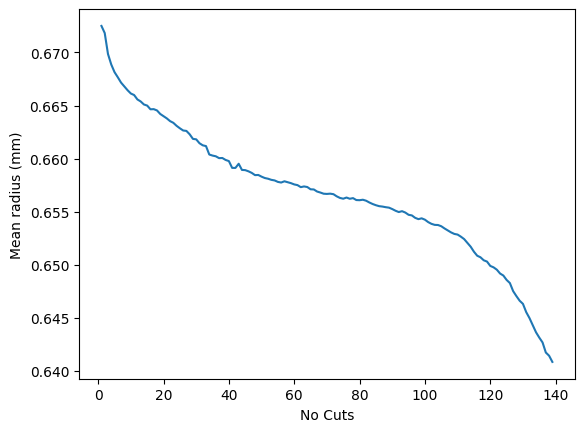

In [7]:
fig, ax = plt.subplots()
ax.plot(data_x, data_y, label='No Cuts')
ax.set_xlabel('No Cuts')
ax.set_ylabel('Mean radius (mm)')

In [46]:
data_x = dfs[0].iloc[1:, :7].values
data_y = dfs[0].iloc[1:, 7].values

In [23]:
idx = np.arange(len(dfs[0][1:]))
train_idx, test_idx = train_test_split(idx, test_size=0.4)
# train_idx = idx[::30]
test_idx = np.setdiff1d(idx, train_idx)
print(f'Dataset size: {len(idx)}')
print(f'Train size: {len(train_idx)}')
print(f'Test size: {len(test_idx)}')

Dataset size: 139
Train size: 83
Test size: 56


(array([ 3.,  1.,  2.,  2.,  1.,  3.,  1.,  4.,  4.,  4.,  3.,  6.,  9.,
        12., 13., 13., 12.,  7.,  6.,  5.,  4.,  5.,  6.,  4.,  3.,  2.,
         1.,  1.,  0.,  2.]),
 array([0.64083764, 0.64189303, 0.64294842, 0.64400381, 0.6450592 ,
        0.64611459, 0.64716998, 0.64822537, 0.64928076, 0.65033615,
        0.65139154, 0.65244693, 0.65350232, 0.65455771, 0.6556131 ,
        0.65666849, 0.65772388, 0.65877927, 0.65983466, 0.66089005,
        0.66194544, 0.66300082, 0.66405621, 0.6651116 , 0.66616699,
        0.66722238, 0.66827777, 0.66933316, 0.67038855, 0.67144394,
        0.67249933]),
 <BarContainer object of 30 artists>)

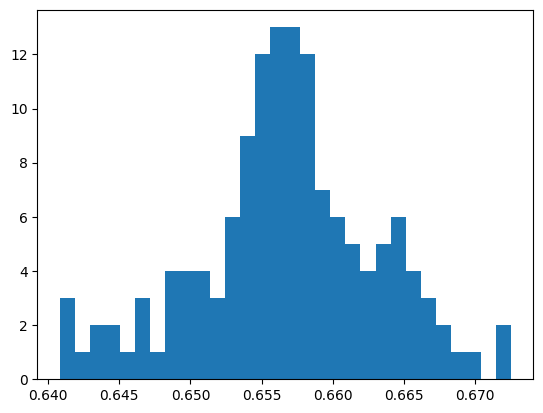

In [24]:
# plot distribution of dataset
fig, ax = plt.subplots()
ax.hist(data_y, bins=30)

## Gaussian Process Regression

### AE features

In [ ]:
data_x = dfs[0].iloc[1:, :7].values
data_y = dfs[0].iloc[1:, 7].values

In [76]:
idx = list(np.arange(data_x.shape[0]))
# tr_idx, te_idx = train_test_split(idx, test_size=0.4)
tr_idx = idx[::10]
te_idx = np.setdiff1d(idx, tr_idx)

In [77]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(data_x[tr_idx], data_y[tr_idx])
gaussian_process.kernel_

c:\Users\tomje\.conda\envs\tf\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.505**2 * RBF(length_scale=27.9)

In [78]:
mean_pred, std_pred = gaussian_process.predict(data_x, return_std=True)

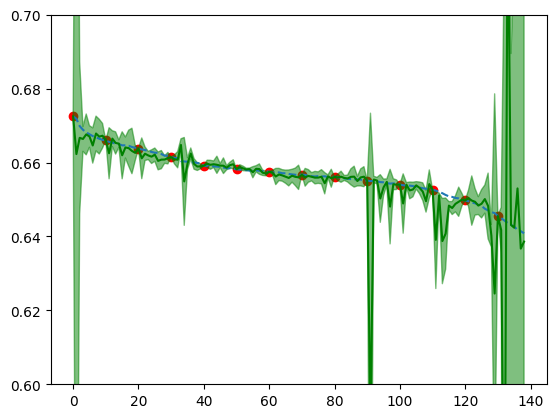

In [79]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data_y)), data_y, label='No Cuts', linestyle='--')
ax.scatter(tr_idx, data_y[tr_idx], label='Train', color='red')
ax.plot(mean_pred, label='Prediction', color='green')
ax.set_ylim(0.6, 0.7)
# ax.plot(mean_pred, label='Prediction', color='green')
# ax.scatter(data_x, data_y, label='Train', color='red')
# ax.plot(mean_pred, label='Prediction', color='green')
ax.fill_between(idx,
                mean_pred.flatten() - 1.96 * std_pred,
                mean_pred.flatten() + 1.96 * std_pred,
                color='green',
                alpha=0.5,
                )


### Radius Features

In [80]:
data_y = dfs[0]['Mean radius'].values[1:].reshape(-1, 1)
data_x = np.arange(1, len(data_y) + 1).reshape(-1, 1)

In [85]:
idx = np.arange(len(dfs[0][1:]))
train_idx = idx[::20]
test_idx = np.setdiff1d(idx, train_idx)

In [86]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(data_x[train_idx], data_y[train_idx])
gaussian_process.kernel_

0.425**2 * RBF(length_scale=81.4)

In [87]:
mean_pred, std_pred = gaussian_process.predict(data_x, return_std=True)

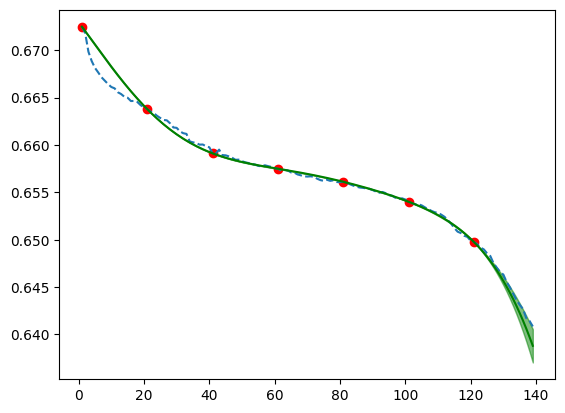

In [88]:
fig, ax = plt.subplots()
ax.plot(data_x, data_y, label='No Cuts', linestyle='--')
ax.scatter(data_x[train_idx], data_y[train_idx], label='Train', color='red')
ax.plot(data_x, mean_pred, label='Prediction', color='green')
ax.fill_between(data_x.flatten(),
                mean_pred.flatten() - 1.96 * std_pred,
                mean_pred.flatten() + 1.96 * std_pred,
                color='green',
                alpha=0.5,
                )


## Forecasting

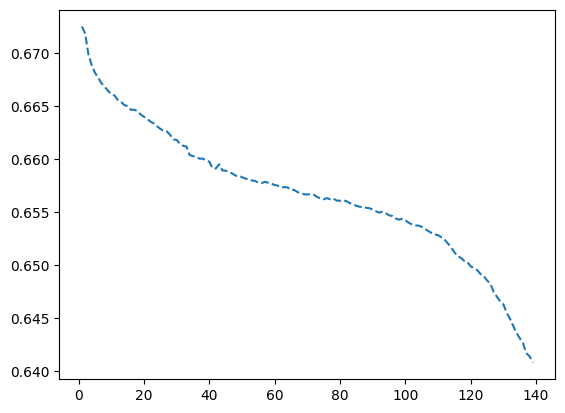

In [156]:
fig, ax = plt.subplots()
ax.plot(data_x, data_y, label='No Cuts', linestyle='--')

In [157]:
from sklearn.gaussian_process import kernels

cutoff = 120

train_idx = idx[:cutoff:10]
test_idx = idx[cutoff:]

kernel = 1.0 * kernels.Matern(length_scale=10, nu=1.5)
# kernel = kernels.DotProduct(sigma_0=0)
# kernel = mat_kernel * lin_kernel

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
y_mean = data_y.mean()
gaussian_process.fit(data_x[train_idx], data_y[train_idx] - y_mean)
gaussian_process.kernel_

mean_pred, std_pred = gaussian_process.predict(data_x, return_std=True)
mean_pred += y_mean

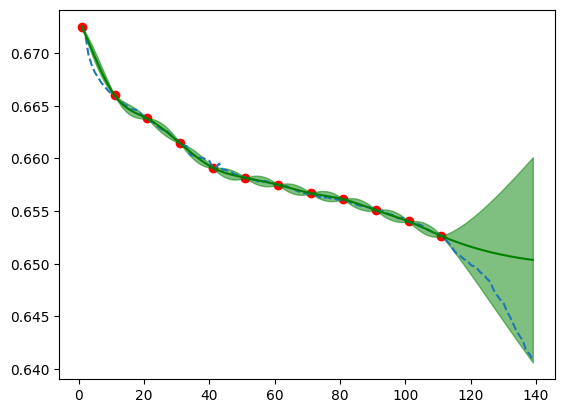

In [158]:
fig, ax = plt.subplots()
ax.plot(data_x, data_y, label='No Cuts', linestyle='--')
ax.scatter(data_x[train_idx], data_y[train_idx], label='Train', color='red')
ax.plot(data_x, mean_pred, label='Prediction', color='green')
ax.fill_between(data_x.flatten(),
                mean_pred.flatten() - 1.96 * std_pred,
                mean_pred.flatten() + 1.96 * std_pred,
                color='green',
                alpha=0.5,
                )